# Gini Coefficient

**Gini Coefficient:** A performance metric for (binary?) classification models.

In [1]:
# Packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# plotting defaults
sns.set_theme()
sns.set(font_scale=1.1)

In [2]:
# constants
RANDOM_SEED = 42

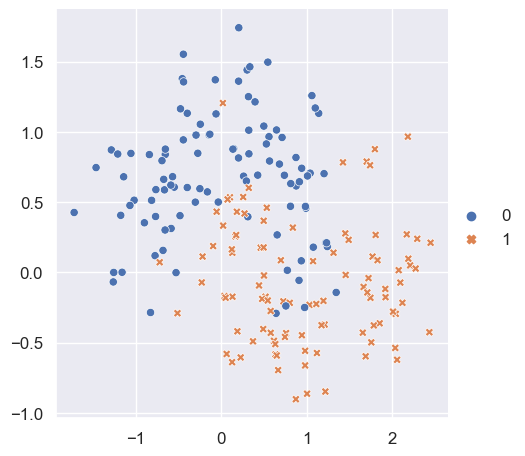

In [3]:
# generate sample data - 2 interleaving half circles
X, y = make_moons(n_samples=200, noise=0.3, random_state=RANDOM_SEED)

sns.relplot(x=X[:, 0], y=X[:, 1], hue=y, style=y);

In [4]:
# train random forest classifier
forest_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    random_state=RANDOM_SEED,
)
forest_clf.fit(X, y)

y_pred = forest_clf.predict(X)
acc = accuracy_score(y, y_pred)
print("Training Accuracy: {:.2f}".format(acc))

Training Accuracy: 0.97


In [5]:
# train logistic regression
log_reg = LogisticRegression()
log_reg.fit(X, y)

y_pred = log_reg.predict(X)
acc = accuracy_score(y, y_pred)
print("Training Accuracy: {:.2f}".format(acc))

Training Accuracy: 0.83


## Cumulative Accuracy Profile (CAP) Curve

*Need to talk about scaling here*
*Also need to add description of `normalised` parameter to `cap.py`*

Consider a binary classification task. We reorder the samples by decreasing confidence that the label is positive. So we start with samples we are sure are positive and end with samples we are sure are negative. We then go through the samples, count how many *are* positive, and plot number of samples against number of positive samples. Finally we scale So the $x$-axis goes from 0 to the number $N$ of samples, and the $y$-axis goes from 0 to the number $N_+$ of positive samples.

A perfect model would accurately put all positive samples first, so the curve would be diagonal from $(0, 0)$ to $(N_+, N_+)$. We would expect a random model to be a straight line from $(0,0)$ to $(N, N_+)$.

We can evaluate a classifier by comparing its cumulative accuracy curve against a perfect and random model. This works best when the classifier gives probabilities.

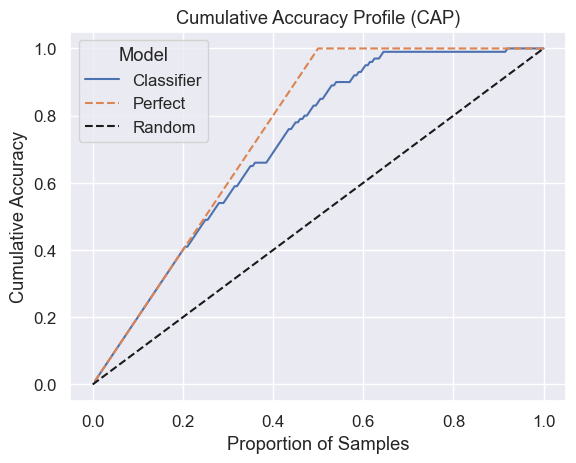

In [7]:
from cap import plot_cumulative_accuracy_profile

plot_cumulative_accuracy_profile(log_reg, X, y, method="predict_proba")